In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav
import matplotlib.pyplot as plt
%matplotlib inline 
import skyclean
from skyclean import CMB_data
from astropy.io import fits


In [3]:
local_path = "../../CMB_plot/BeamWf_HFI_R3.01/"

# Open the FITS file
hfi = fits.open(local_path + "Bl_T_R3.01_fullsky_857x857.fits")

In [9]:

temperature_data = hfi[1].data['TEMPERATURE']

In [12]:
temperature_data

array([1.        , 0.99999923, 0.99999762, ..., 0.1245206 , 0.12438423,
       0.12424795])

In [4]:
print(hfi.info())
print(hfi[1].data.shape[0])    

Filename: ../../CMB_plot/BeamWf_HFI_R3.01/Bl_T_R3.01_fullsky_857x857.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  WINDOW FUNCTION    1 TableHDU        26   4001R x 1C   [E15.7]   
None
4001


In [14]:
CMB_data_30.show_attributes()

Attributes:
 [['path', '../data/planck_simulation/ffp10_newdust_total_857_full_map.fits'], ['nside', 2048], ['lmax usually 2 * nisde', 4096]]
Maps:
 [['original_hp_map', 'Available'], ['original_mw_map', None], ['reconstructed_hp_map', None], ['reconstructed_mw_map', None]]
Alms:
 [['original_hp_alm', 'Available'], ['reconstructed_hp_alm', None]]
Wavelet_related:
 [['wavelet_coeff', None], ['Scaling_coeff', None]]


In [6]:
CMB_map_path = '../data/planck_simulation/ffp10_newdust_total_857_full_map.fits'
CMB_data_30 = skyclean.CMB_data.CMB_Data(CMB_map_path)

# Store get mw alm
CMB_data_30.original_hp_alm = hp.map2alm(CMB_data_30.original_hp_map, lmax=hfi[1].data.shape[0])
CMB_data_30.original_mw_alm = CMB_data_30.hp_alm_to_mw_alm(CMB_data_30.original_hp_alm, lmax=hfi[1].data.shape[0])

CMB_data_30.original_mw_alm.shape

CMB_Data object created, (use show_attributes() to check the attributes)


(4001, 8001)

In [13]:
# Deconvolve the beam window function from the CMB data
CMB_data_30_beam_deconvolved = np.zeros(CMB_data_30.original_mw_alm.shape, dtype=np.complex128)

for i in range(CMB_data_30.original_mw_alm.shape[1]):
    CMB_data_30_beam_deconvolved[:, i] = CMB_data_30.original_mw_alm[:, i] / temperature_data
CMB_data_30_beam_deconvolved.shape
# print(CMB_data_30_beam_deconvolved)

(4001, 8001)

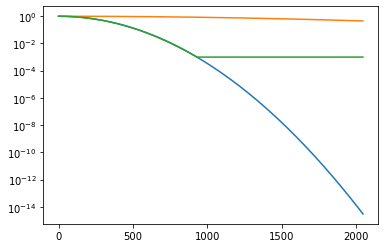

In [12]:
# plt.plot(bl)
# # plt.yscale('log')
# plt.plot(Standard_bl)
# plt.yscale('log')
# plt.plot(thresholded_bl)


In [ ]:
# alm / beam/ pix * new beam 

In [2]:


def vertical_operation(mw_alm, bl,operation):
    """
    Perform a vertical operation of each column of the original_mw_alm matrix by the thresholded_bl vector.
    
    Parameters:
    original_mw_alm (ndarray): The original matrix to be divided.
    thresholded_bl (ndarray): The vector by which each column of the matrix will be divided.
    
    Returns:
    ndarray: A new matrix with each column of original_mw_alm divided by thresholded_bl.
    """
    # # Ensure thresholded_bl is a column vector for broadcasting
    # thresholded_bl = thresholded_bl[:, np.newaxis]
    
    # # Perform the division
    # beam_deconvolved = original_mw_alm / thresholded_bl
    beam_deconvolved = np.zeros(mw_alm.shape, dtype=np.complex128)

    if operation == '*':
        for i in range(mw_alm.shape[1]):
            beam_deconvolved[:, i] = mw_alm[:, i] * bl
    elif operation == '/':
        for i in range(mw_alm.shape[1]):
            beam_deconvolved[:, i] = mw_alm[:, i] / bl
    else:
        raise ValueError("Operation must be '*' or '/'")


    return beam_deconvolved

# Example usage
# Assuming CMB_data_30.original_mw_alm and thresholded_bl are already defined
CMB_data_30_beam_deconvolved_1 = vertical_operation(CMB_data_30.original_mw_alm, thresholded_bl,"/")

# Check the shape
print(CMB_data_30_beam_deconvolved==CMB_data_30_beam_deconvolved_1)


[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [18]:
# Convert arcminutes to radians
def arcmin_to_radians(arcmin):
    return np.radians(arcmin / 60)


# Get the Pixel Window Function for the specified nside
pixwin = hp.sphtfunc.pixwin(CMB_data_30.nside, lmax=hfi[1].data.shape[0]-1, pol=False)

print(pixwin.shape)
# print(pixwin.min())

(4001,)


In [19]:
CMB_data_30_pix_beam_deconvolved = np.zeros(CMB_data_30.original_mw_alm.shape, dtype=np.complex128)

for i in range(CMB_data_30.original_mw_alm.shape[1]):
    CMB_data_30_pix_beam_deconvolved[:, i] = CMB_data_30_beam_deconvolved[:, i] / pixwin
CMB_data_30_pix_beam_deconvolved.shape

(4001, 8001)

In [20]:
fwhm_rad = arcmin_to_radians(5)
Standard_bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=hfi[1].data.shape[0]-1, pol=False)

print(Standard_bl.shape)

(4001,)


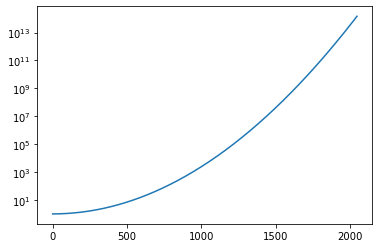

In [6]:
plt.plot(Standard_bl/bl)
plt.yscale('log')

In [21]:
deconvolved_CMB_data_30 = np.zeros(CMB_data_30.original_mw_alm.shape, dtype=np.complex128)   


for i in range(CMB_data_30.original_mw_alm.shape[1]):
    deconvolved_CMB_data_30[:, i] = CMB_data_30_pix_beam_deconvolved[:, i] * Standard_bl
deconvolved_CMB_data_30.shape

(4001, 8001)

In [23]:
processed_30_hp_alm = CMB_data_30.mw_alm_to_hp_alm(deconvolved_CMB_data_30, lmax=deconvolved_CMB_data_30.shape[0])

processed_30_hp_map = hp.alm2map(processed_30_hp_alm, nside=CMB_data_30.nside, lmax=deconvolved_CMB_data_30.shape[0]-1)

hp.mollview(
        CMB_data_30.original_hp_map,
        coord=["G"],
        title="Full Sky CMB at "+"857",
        # unit=r"$\mu$K",
        # min=-300, 
        # max=300,
    )


hp.mollview(
        processed_30_hp_map,
        coord=["G"],
        title="Full Sky CMB at "+"857",
        # unit=r"$\mu$K",
        # min=-300, 
        # max=300,
    )

# CMB_data_30.plot_mollview(CMB_data_30.original_hp_map, title='Original 857 GHz Map')
# CMB_data_30.plot_mollview(processed_30_hp_map, title='Processed 857 GHz Map')

# CMB_data_30.plot_mollview(CMB_data_30.original_hp_map - processed_30_hp_map, title='Difference Map')

# CMB_data_30.plot_mollview(processed_30_hp_map+(CMB_data_30.original_hp_map - processed_30_hp_map), title='check Map')